In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from scipy.stats import multivariate_normal as normal
import matplotlib
import matplotlib.cm as cm
from sklearn import datasets
from math import *
import seaborn as sns; sns.set_style('white')
import tikzplotlib
from tqdm import tqdm, trange
from pycalib.calibration_methods import PlattScaling, TemperatureScaling

# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5,5)
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['lines.linewidth'] = 1.0
plt = matplotlib.pyplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def plot_separate(X, Y, X1_test, X2_test, pys, confs, names, fname, size=120):
    ims = []
    cmap = 'Blues'
    
    save_cbar = True
    
    for name, py, conf in zip(names, pys, confs):
        levels = np.arange(0.5, 1.01, 0.1)
        lws = [0.5]*5 + [3] + [0.5]*5
        
        cnt_decbdry = plt.contour(X1_test, X2_test, py.reshape(size, size), levels=[0.5], colors='black', linewidths=[3])
#         plt.clabel(cnt_decbdry, inline=True, fontsize=16, fmt='%.1f')
        
#         cnt = plt.contour(X1_test, X2_test, conf.reshape(size, size), levels=np.arange(0.5, 1.01, 0.1), colors='black', linewidths=1, vmin=0.5, vmax=1)
#         plt.clabel(cnt, inline=True, fontsize=16, fmt='%.1f')
        
        norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
        im = plt.contourf(X1_test, X2_test, conf.reshape(size, size), alpha=0.7, levels=np.arange(0.5, 1.01, 0.1), cmap=cmap, vmin=0.5, vmax=1)
        
        plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', edgecolors='k', linewidths=0.1)
        plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k', linewidths=0.1)

        plt.xlim(test_range);
        plt.ylim(test_range);
        plt.xticks([])
        plt.yticks([])
        plt.savefig(f'figs/{fname}_{name}.pdf', bbox_inches='tight')
#         tikzplotlib.save(f'figs/{fname}_{name}.tex')

        if save_cbar:
            # draw a new figure and replot the colorbar there
            fig, ax = plt.subplots()
            plt.colorbar(im, ax=ax)
            ax.remove()
            plt.savefig(f'figs/{fname}_colorbar.pdf', bbox_inches='tight')
            save_cbar = False
        
        plt.show();

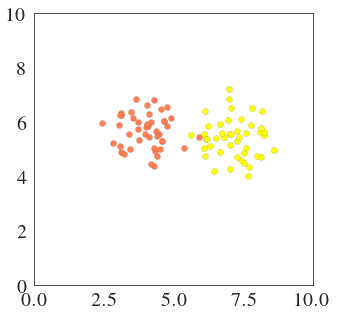

In [4]:
np.random.seed(7777)
size = 90
train_range = (4, 7.5)


X, Y = datasets.make_blobs(n_samples=size, centers=2, cluster_std=0.7, 
                           center_box=train_range, random_state=62)

test_range = (0, 10)

plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', edgecolors='k', linewidths=0.1)
plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k', linewidths=0.1)
plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='magenta', edgecolors='k', linewidths=0.1)
plt.scatter(X[Y==3][:, 0], X[Y==3][:, 1], c='white', edgecolors='k', linewidths=0.1)
plt.xlim(test_range);
plt.ylim(test_range);


def sigm(x):
    return 1/(1+np.exp(-x))

In [5]:
torch.manual_seed(99999)

m, n = X.shape
h = 20
k = 1

X_t = torch.from_numpy(X).float()
Y_t = torch.from_numpy(Y).float()


class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()

        self.feature_extr = nn.Sequential(
            nn.Linear(n, h),
            nn.BatchNorm1d(h),
            nn.ReLU(), 
            nn.Linear(h, h), 
            nn.BatchNorm1d(h),
            nn.ReLU(),
#             nn.Linear(h, h), 
#             nn.BatchNorm1d(h),
#             nn.ReLU(),
        )

        self.clf = nn.Linear(h, 1, bias=False)
    
    def forward(self, x):
        x = self.feature_extr(x)
        return self.clf(x)
    
    
model = Model()
print(np.sum([p.numel() for p in model.parameters()]))
    
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
# opt = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

# pbar = trange(5000, position=0, leave=True)
pbar = range(5000)
for it in pbar:
    y = model(X_t).squeeze()
    l = F.binary_cross_entropy_with_logits(y, Y_t, reduction='mean')
    l.backward()
    opt.step()
    opt.zero_grad()
    
#     pbar.set_description(f'Loss: {l.item():.3f}')
    
print(f'Loss: {l.item():.3f}')

# torch.save(model.state_dict(), 'pretrained_models/relu_bnn_clf_2d.th')

580
Loss: 0.023


Temp: 8.058094024658203
997995.9939879759
100


100%|██████████| 2500/2500 [00:01<00:00, 1458.29it/s]


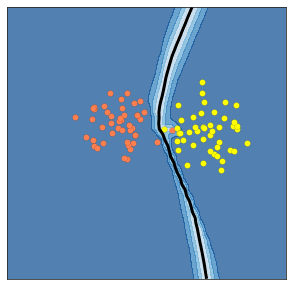

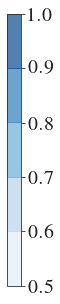

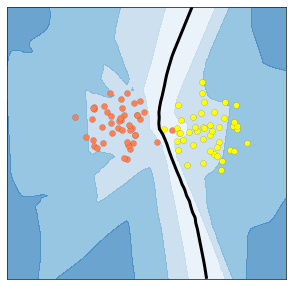

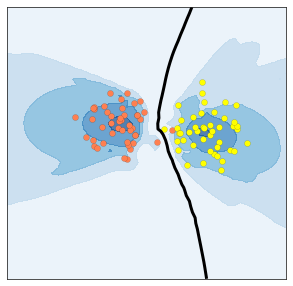

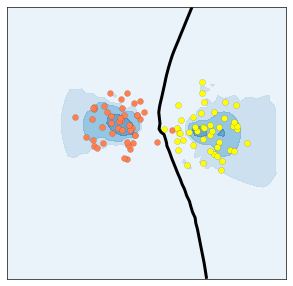

In [6]:
model.eval()

# Validation data
X_val, y_val = datasets.make_blobs(n_samples=50, centers=2, cluster_std=0.7, 
                                   center_box=train_range, random_state=1)
X_val, y_val = torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()

# Test data
size = 50
# test_range = (-100, 100); zo = True
test_range = (0, 10); zo = False
test_rng = np.linspace(*test_range, size)
X1_test, X2_test = np.meshgrid(test_rng, test_rng)
X_test = np.stack([X1_test.ravel(), X2_test.ravel()]).T

X_test_t = torch.from_numpy(X_test).float()

with torch.no_grad():
    model.eval()
    py_map = sigm(model(X_test_t).squeeze().numpy())
    
conf_map = np.maximum(py_map, 1-py_map)

    
''' ============================== Temp ================================='''

logit_val = model(X_val).squeeze().detach()

T = torch.tensor(1).float()
T.requires_grad = True

optimizer = optim.LBFGS([T], lr=0.1, max_iter=50)

def eval():
    optimizer.zero_grad()
    loss = F.binary_cross_entropy_with_logits(logit_val/T, y_val)
    loss.backward()
    return loss

optimizer.step(eval)

T = T.detach().item()
print(f'Temp: {T}')


with torch.no_grad():
    logit_test = model(X_test_t).squeeze().numpy()
    py_temp = sigm(logit_test/T)
    
conf_temp = np.maximum(py_temp, 1-py_temp)
    

''' ============================== LLLA ================================='''

from hessian import exact_hessian
from torch.distributions.multivariate_normal import MultivariateNormal
torch.set_printoptions(precision=1, profile='full')


# model.load_state_dict(torch.load('pretrained_models/relu_bnn_clf_2d.th'))
# model.eval()

W = list(model.parameters())[-1]
shape_W = W.shape


def neg_log_post(var0):
    nll = F.binary_cross_entropy_with_logits(model(X_t).squeeze(), Y_t, reduction='sum')
    nlp = 1/2 * W.flatten() @ (1/var0 * torch.eye(W.numel())) @ W.flatten()

    return nll + nlp


def llla_predict(x, var0, apply_sigm=True):
    model.eval()
    loss = neg_log_post(var0)
    Prec_post = exact_hessian(loss, [W])
    
    with torch.no_grad():
        w_map = list(model.parameters())[-1].view(-1).data.numpy()
        Cov_post = torch.inverse(Prec_post).numpy()

        phi = model.feature_extr(x).numpy()
        kappa = lambda var: (1+pi*var/8)**(-1/2)
        mu_pred = phi @ w_map

        # LLLA
        Cov_pred = phi @ Cov_post @ phi.T
        var_pred = np.diag(Cov_pred)
        z = kappa(var_pred)*mu_pred
        py_llla = sigm(z) if apply_sigm else z
        
    return py_llla


def optimize_var0(x_val, y_val):
    var0s = np.linspace(1, 1000000, 500)
    nlls = []
        
    X_out = torch.from_numpy(np.random.uniform(*train_range, size=[50, 2])).float()
    y_out = torch.tensor([0.5]*50).float()
    
    pbar = tqdm(var0s, position=0, leave=True)

    for var0 in pbar:
        out_in = llla_predict(x_val, var0, apply_sigm=False)
        out_in = torch.from_numpy(out_in).float()
        loss = F.binary_cross_entropy_with_logits(out_in, y_val).detach().item()
        
        out_out = llla_predict(X_out, var0, apply_sigm=False)
        out_out = torch.from_numpy(out_out).float()
        loss += F.binary_cross_entropy_with_logits(out_out, y_out).detach().item()
        
        nlls.append(loss)

        pbar.set_description(f'var0: {var0:.3f}, Loss: {loss:.3f}')
            
    best_var0 = var0s[np.argmin(nlls)]

    return best_var0


# var0 = optimize_var0(X_val, y_val)
var0 = 997995.9939879759  # Optimal value from the above
print(var0)

py_llla = llla_predict(X_test_t, var0)
conf_llla = np.maximum(py_llla, 1-py_llla)
    


''' ============================== Full-Laplace ================================='''

from laplace import diag_laplace

model_full = diag_laplace.DiagLaplace(model)
interval = np.linspace(0.0001, 100, 100)
# var0 = model_full.optimize_var0(X_t, Y_t, X_val, y_val, interval, rng_ood=train_range)
var0 = 100  # This is the optimal value

print(var0)

model_full.estimate_variance_batch(X_t, Y_t, var0)

# print(model_full.hessian); input()

py_full = model_full.forward_linearized(X_test_t).detach().numpy()
conf_full = np.maximum(py_full, 1-py_full)


# names = ['map', 'llla', 'dla', 'kfla']
names = ['map', 'temp', 'llla', 'fullla']
if zo:
    names = [name + '_zoomedout' for name in names]
    
pys = [py_map, py_temp, py_llla, py_full]
confs = [conf_map, conf_temp, conf_llla, conf_full]

plot_separate(X, Y, X1_test, X2_test, pys, confs, names, fname='toy_2d_bnn_exp', size=size)